In [29]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径




# 设置种子以确保实验的可重复性
torch.manual_seed(42)
np.random.seed(42)


In [30]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\趋势变量+噪声变量\\趋势变量加随机噪声-专用数据1.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='建模-分量-全部') 
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\数据-时间戳.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='Sheet4') 
# print(df_sheet.info())
# print(df_sheet.columns)


In [31]:
# 定义输入输出参数
input_term = ['冷风压力', '冷风流量', '热风温度', '设定喷煤量']
output_term = ['铁口1温度','SI']
time_term= '时间戳'


In [32]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()

# 定义一个函数，用中位数替换异常值
def replace_outliers_with_median(series):
    # 计算列的中位数
    median_value = series.median()
    # 检测异常值
    outliers = (series - median_value).abs() > 3.0 * series.std()  # 使用标准差作为阈值
    # 使用中位数替换异常值
    series[outliers] = median_value
# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# replace_outliers_with_median(df_sheet_process[input_term[0]])
# replace_outliers_with_median(df_sheet_process[input_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[0]])
# replace_outliers_with_median(df_sheet_process[output_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[2]])
# replace_outliers_with_median(df_sheet_process[output_term[3]])

# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(input_term+output_term):
    
#     plt.subplot(len(input_term+output_term), 1, idx+1)
#     plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




In [33]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'m-')
    plt.plot(data_x[index_predict],data_y[index_predict],'r-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签

length1 = 804
start1 = 0
length2 = 804
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


# plt.figure(figsize=(15, 10))
# for idx, column in enumerate(input_term+output_term):
#     plt.subplot(len(input_term+output_term), 1, idx+1)
#     plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [34]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet[input_term[0]].values,
    input_term[1]:   df_sheet[input_term[1]].values,
    input_term[2]:   df_sheet[input_term[2]].values,
    input_term[3]:   df_sheet[input_term[3]].values,
    output_term[0]:  df_sheet[output_term[0]].values,
    output_term[1]:  df_sheet[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [35]:
# # 标定归一化前后数据
# data_point = np.array([1500]).reshape(-1, 1)
# data1 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# data_point = np.array([1510]).reshape(-1, 1)
# data3 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每摄氏度的输出差：',(data3-data1)/(data4-data2))



# data_point = np.array([0.5]).reshape(-1, 1)
# data1 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# data_point = np.array([0.6]).reshape(-1, 1)
# data3 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每0.01浓度的输出差：',(data3-data1))


In [36]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,test_size):
    # 假设您有六个时间序列数据
    # u1_data, u2_data, u3_data, u4_data, y1_data, y2_data 是形状为 (800, 1) 的 NumPy 数组

    # 堆叠输入和输出数据
    X = np.column_stack((u1_data, u2_data, u3_data, u4_data, y1_data, y2_data))
    y = np.column_stack((y1_data, y2_data))
    # print('X',X.shape)

    # 定义时间步数和特征数
    time_steps = 5
    features = 6

    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    for i in range(len(X) - time_steps):
        X_sample = X[i:i + time_steps, :]
        y_sample = y[i + time_steps, :]  # 取每个序列的第11个时刻作为输出
        # print(i,i + time_steps,i + time_steps)
        X_modified.append(X_sample)
        y_modified.append(y_sample)

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)

    # 打印新数据的形状
    print("Modified Input Shape:", X_modified.shape)
    print("Modified Output Shape:", y_modified.shape)

    isShuffle = True
    # isShuffle = False

    X_train, X_test, y_train, y_test = train_test_split(X_modified, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test,X_modified, y_modified

def make_data2(u1_data,u2_data,u3_data,u4_data,y1_data,y2_data,test_size):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)

    y1_data = y1_data
    y2_data = y2_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1],
                            y1_data  [1:-1], y2_data  [1:-1])
                        )
    y = np.column_stack((y1_data[2:],y2_data[2:]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    y_reshaped = y.reshape((y.shape[0], 1, y.shape[1]))
    print('总数据数量：',y.shape)


    isShuffle = True
    # isShuffle = False

    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)




    y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    y_val = y_val.reshape((y_val.shape[0],y_val.shape[2]))
    y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test,X_reshaped, y_reshaped



In [37]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = normalized_data_dict[output_term[1]][index_gaolu]
num_samples = y2_data.shape[0]

print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test,X_modified, y_modified = make_data(u1_data,u2_data,u3_data,u4_data,
                                                            y1_data,y2_data,
                                                            test_size=test_size)



高炉模型数据
Modified Input Shape: (800, 5, 6)
Modified Output Shape: (800, 2)
训练数量： (559, 5, 6) (559, 2)
验证数量： (121, 5, 6) (121, 2)
测试数量： (120, 5, 6) (120, 2)


In [38]:

X_modified_tensor = torch.tensor(X_modified)
X_modified_tensor = X_modified_tensor.to(torch.float32) 
X_modified_tensor.shape

X_gaolu_train_tensor = torch.tensor(X_gaolu_train)
X_gaolu_train_tensor = X_gaolu_train_tensor.to(torch.float32) 
X_gaolu_train_tensor.shape

X_gaolu_val_tensor = torch.tensor(X_gaolu_val)
X_gaolu_val_tensor = X_gaolu_val_tensor.to(torch.float32) 
X_gaolu_val_tensor.shape


X_gaolu_test_tensor = torch.tensor(X_gaolu_test)
X_gaolu_test_tensor = X_gaolu_test_tensor.to(torch.float32) 
X_gaolu_test_tensor.shape


torch.Size([120, 5, 6])

In [39]:
# 自编码器
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # 将输出限制在 [0, 1] 的范围内
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

# # 准备训练数据
# train_data = torch.randn(559, 5, 6)  # 训练数据集形状为 (样本数, 时间步, 特征数)
# train_labels = torch.randn(559, 2)   # 标签形状为 (样本数, 输出特征数)

# 定义输入维度、隐藏层维度和输出维度
input_size = 6  # 输入特征数
hidden_size = 128
output_size = 6

# 创建模型实例
Autoencoder_model = Autoencoder(input_size, hidden_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Autoencoder_model.parameters(), lr=0.0015)

# 模型训练
epochs = 200
loss_list = []
for epoch in range(epochs):
    optimizer.zero_grad()
    encoded,outputs = Autoencoder_model(X_modified_tensor)  # 前向传播
    loss = criterion(outputs, X_modified_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新模型参数
    loss_list.append(loss.item())
    if epoch % 1 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}", end='\r')



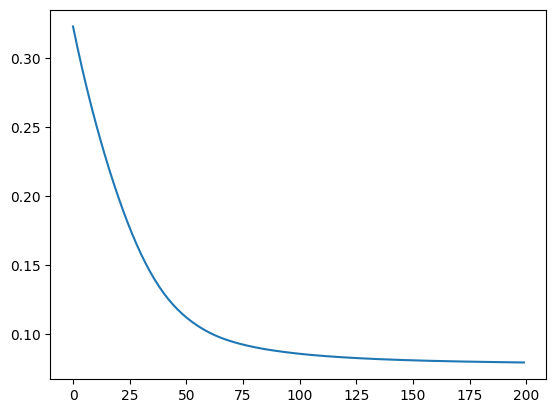

In [40]:
plt.plot(loss_list[:])


In [41]:
X_gaolu_train_encoded,outputs = Autoencoder_model(X_gaolu_train_tensor)
X_gaolu_val_encoded,outputs = Autoencoder_model(X_gaolu_val_tensor)
X_gaolu_test_encoded,outputs = Autoencoder_model(X_gaolu_test_tensor)

X_gaolu_train_encoded.shape


torch.Size([559, 5, 128])

In [42]:
# PCA降维
from sklearn.decomposition import PCA
import numpy as np
PCA_features = 16

def pca(data, n_components):
    # Step 1: 数据中心化
    mean = np.mean(data, axis=0)
    centered_data = data - mean

    # Step 2: 计算协方差矩阵
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Step 3: 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: 选择主成分
    sorted_indices = np.argsort(eigenvalues)[::-1]  # 按特征值从大到小排序
    selected_eigenvectors = eigenvectors[:, sorted_indices[:n_components]]

    # Step 5: 投影数据
    projected_data = np.dot(centered_data, selected_eigenvectors)

    return projected_data
def PCA_jiangwei(data):
    # 假设data是你的数据，维度为[559, 5, 32]
    data = data.detach().numpy()
    # 将数据重塑为二维数组，以便进行PCA处理
    reshaped_data = data.reshape(-1, 128)
    # 对数据进行PCA降维
    pca_data = pca(reshaped_data,n_components=PCA_features)
    # 将降维后的数据重新塑形回原始形状
    pca_data = pca_data.reshape(-1, 5, 16)
    return torch.tensor(pca_data, dtype=torch.float32)


# X_gaolu_train_encoded = PCA_jiangwei(X_gaolu_train_encoded)
# X_gaolu_val_encoded = PCA_jiangwei(X_gaolu_val_encoded)
# X_gaolu_test_encoded = PCA_jiangwei(X_gaolu_test_encoded)



In [43]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 2)
        else:
            self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_train) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [44]:
# 建立高炉模型实例
features_size = 128
hidden_size = 16
# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []



第 25/25 轮, 训练误差: 0.0310, 验证误差: 0.0058
epoch_sum: 25


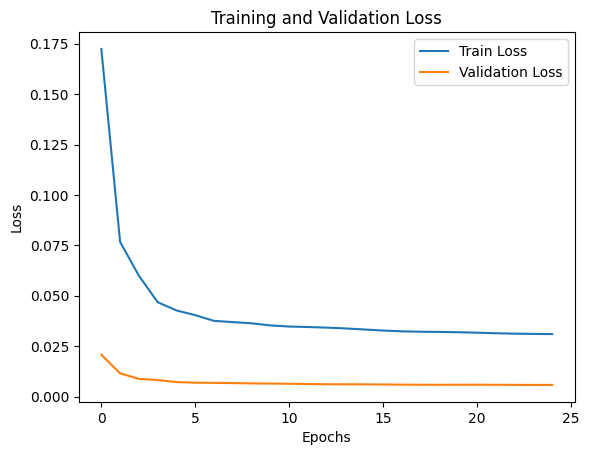

In [45]:
# 高炉模型训练
epoch_once = 25
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train_encoded, y_gaolu_train,
                                    X_gaolu_val_encoded, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 7.3497 , SI: 0.0649 
MAPE:  铁口1温度: 0.2957% , SI: 11.1645%
MRE :  铁口1温度: 0.0030  , SI: 0.1116 


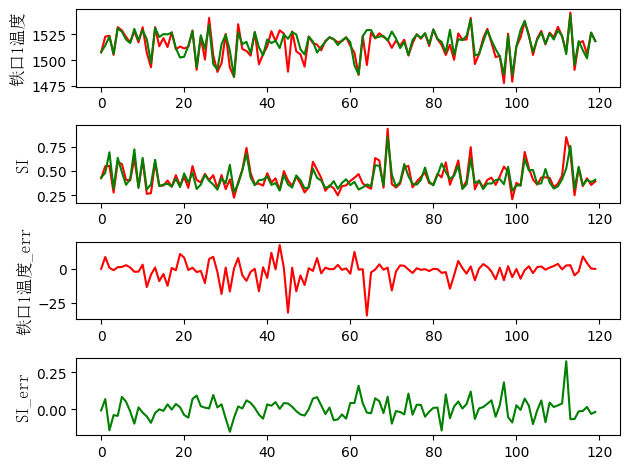

In [46]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test_encoded)
# 计算 RMSE、MRE
y_test = y_gaolu_test





y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")

y_pred_0_gaijin = y_pred_0_inverse_transform
y_pred_1_gaijin = y_pred_1_inverse_transform
plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



In [47]:
# 建立高炉模型实例
features_size = 6
hidden_size = 16
# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []



第 25/25 轮, 训练误差: 0.0432, 验证误差: 0.0069
epoch_sum: 25


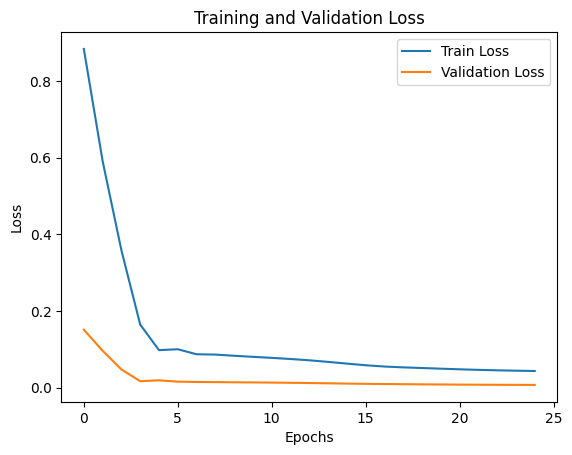

In [48]:
# 高炉模型训练
epoch_once = 25
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 8.3630 , SI: 0.0748 
MAPE:  铁口1温度: 0.3989% , SI: 14.0585%
MRE :  铁口1温度: 0.0040  , SI: 0.1406 


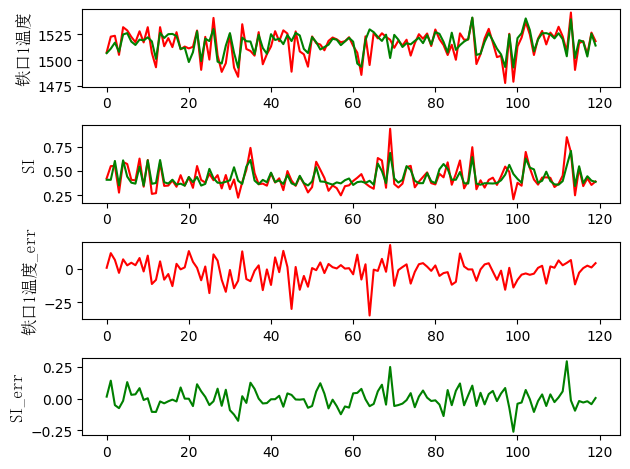

In [49]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test




y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



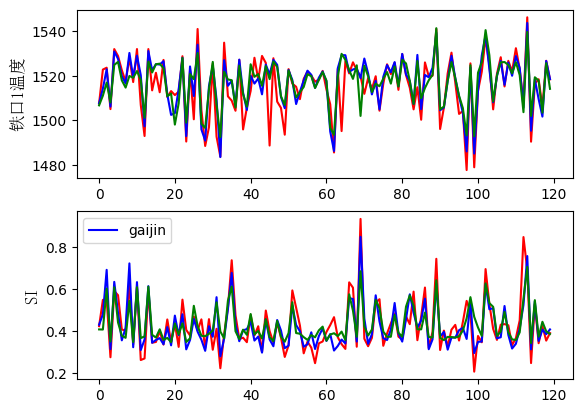

In [57]:
plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r', label='raw')
plt.plot(y_pred_0_gaijin,'b', label='gaijin')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(2, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_gaijin,'b', label='gaijin')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签


plt.legend()
plt.show()

